# Laboratory 3

### Configuration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import pandas as pd


TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfaces

[Available colors](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Available points markers](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines
    
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Next')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Previous')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Add point')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Add line')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Add figure')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Solution

In [4]:
%matplotlib notebook

In [5]:
TOLERANCE = 1e-13

### Function for computing 2x2 determinant

In [6]:
def det2x2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

### Function for getting indexes of points with minimum and maximum value of y

In [7]:
def getMinMaxYIndexes(points):
    minIndex, maxIndex = 0, 0
    for i in range(1, len(points)):
        x, y = points[i]
        if y < points[minIndex][1]:
            minIndex = i
        elif y > points[maxIndex][1]:
            maxIndex = i
    
    return minIndex, maxIndex

### Function for checking if the polygon is y-monotone

In [8]:
def isYMonotone(points):
    n = len(points)
    minIndex, maxIndex = getMinMaxYIndexes(points)
    
    prev = maxIndex
    while prev != minIndex:
        curr = (prev + 1) % n
        if points[prev][1] <= points[curr][1]:
            return False
        prev = curr
        
    prev = maxIndex
    while prev != minIndex:
        curr = (prev - 1 + n) % n
        if points[prev][1] <= points[curr][1]:
            return False
        prev = curr
    
    return True

### Function for classyfing the points

In [9]:
def classifyPoints(points):
    n = len(points)
    classifiedPoints = {"START": [], "END": [], "JOIN": [], "DIV": [], "CORRECT": []}
    
    for curr in range(n):
        prev = (curr - 1 + n) % n 
        next = (curr + 1) % n
        x, y = points[curr]
        x_prev, y_prev = points[prev]
        x_next, y_next = points[next]
        
        if y_prev > y > y_next or y_next > y > y_prev:
            classifiedPoints["CORRECT"].append((x, y))
        elif y_prev < y and y_next < y:
            if det2x2((x_prev, y_prev), (x, y), (x_next, y_next)) > TOLERANCE:
                classifiedPoints["START"].append((x, y))
            else:
                classifiedPoints["DIV"].append((x, y))
        else:
            if det2x2((x_prev, y_prev), (x, y), (x_next, y_next)) > TOLERANCE:
                classifiedPoints["END"].append((x, y))
            else:
                classifiedPoints["JOIN"].append((x, y))
                
    return classifiedPoints

### Function for visualizing classified points

In [10]:
def visualizeClassifiedPoints(points, lines=[]):
    scene = Scene([PointsCollection(points["START"], color = "green"), PointsCollection(points["END"], color = "red"),
                    PointsCollection(points["JOIN"], color = "navy"), PointsCollection(points["DIV"], color = "lightblue"),
                    PointsCollection(points["CORRECT"], color = "brown")], [LinesCollection(lines)])
    plot = Plot(scenes = [scene])
    plot.draw()

### Function returning list of lines from list of points of polygon

In [11]:
def pointsToLines(points):
    n = len(points)
    lines = []
    for i in range(n):
        x, y = points[i]
        x_next, y_next = points[(i + 1) % n]
        lines.append([(x, y), (x_next, y_next)])
    
    return lines

False


<IPython.core.display.Javascript object>


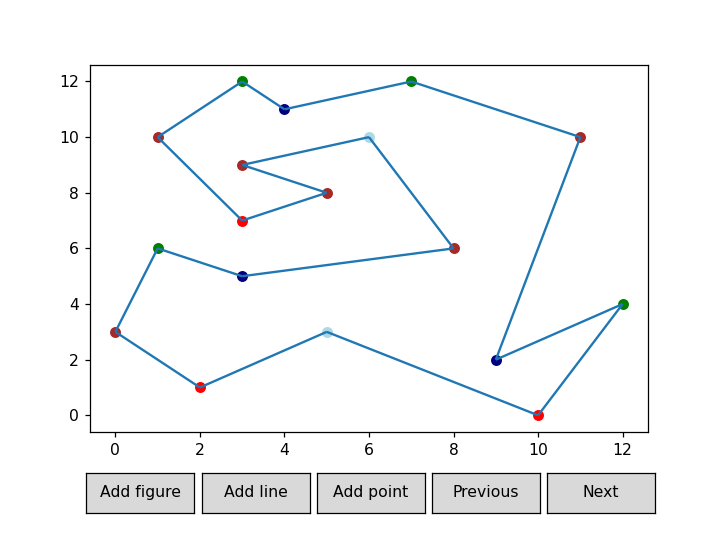

In [53]:
A = [(0, 3), (2, 1), (5, 3), (10, 0), (12, 4), (9, 2), (11, 10), (7, 12), (4, 11), (3, 12), (1, 10), (3, 7), (5, 8), (3, 9), (6, 10), (8, 6), (3, 5), (1, 6)]
print(isYMonotone(A))
points = classifyPoints(A)
visualizeClassifiedPoints(points, pointsToLines(A))

True


<IPython.core.display.Javascript object>


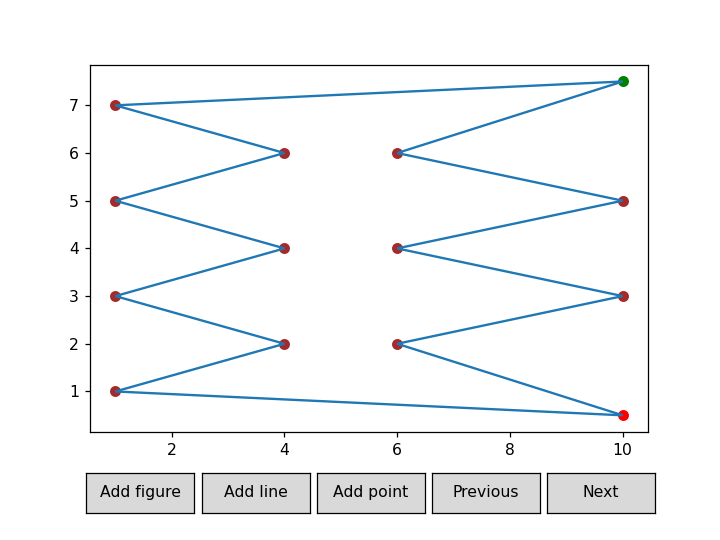

In [52]:
B = [(1, 1), (10, 0.5), (6, 2), (10, 3), (6, 4), (10, 5), (6, 6), (10, 7.5), (1, 7), (4, 6), (1, 5), (4, 4), (1, 3), (4, 2)]
print(isYMonotone(B))
points = classifyPoints(B)
visualizeClassifiedPoints(points, pointsToLines(B))

True


<IPython.core.display.Javascript object>


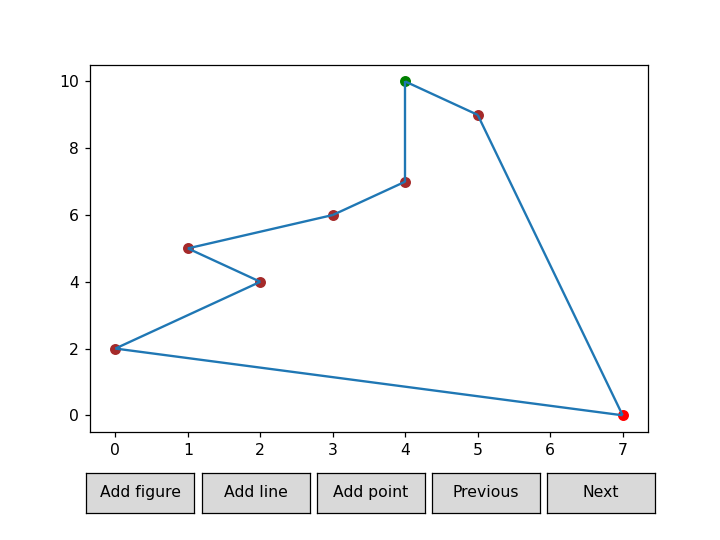

In [51]:
C = [(0, 2), (7, 0), (5, 9), (4, 10), (4, 7), (3, 6), (1, 5), (2, 4)]
print(isYMonotone(C))
points = classifyPoints(C)
visualizeClassifiedPoints(points, pointsToLines(C))

True


<IPython.core.display.Javascript object>


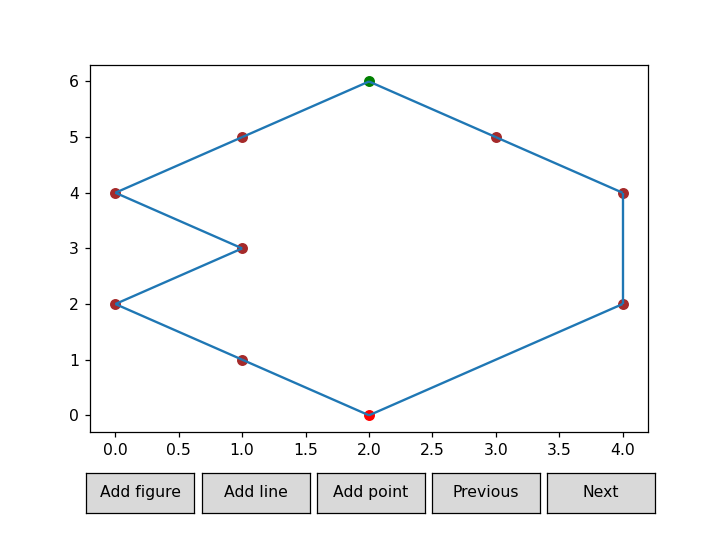

In [50]:
D = [(0, 2), (1, 1), (2, 0), (4, 2), (4, 4), (3, 5), (2, 6), (1, 5), (0, 4), (1, 3)]
print(isYMonotone(D))
points = classifyPoints(D)
visualizeClassifiedPoints(points, pointsToLines(D))

### Function for triangulation of the polygon

In [91]:
def sortByY(points):
    n = len(points)
    minIndex, maxIndex = getMinMaxYIndexes(points)
    dividedPoints = []
    for i in range(n):
        if minIndex < i <= maxIndex:
            dividedPoints.append((points[i], 0))
        else:
            dividedPoints.append((points[i], 1))
            
    cnt = 0
    res = []
    i, j = (maxIndex + 1) % n, (maxIndex - 1 + n) % n
    res.append(dividedPoints[maxIndex])
    while cnt < n - 2:
        x_l, y_l = dividedPoints[i][0]
        x_r, y_r = dividedPoints[j][0]
        if i != minIndex and (y_l > y_r or y_l == y_r and x_l > x_r):
            res.append(dividedPoints[i])
            i = (i + 1) % n
        elif j != minIndex:
            res.append(dividedPoints[j]) 
            j = (j - 1 + n) % n
            
        cnt += 1
    
    res.append(dividedPoints[minIndex])
    return res

def belongs(v1, v2, v3, side):
    det = det2x2(v1, v2, v3)
    if side == 1:
        return det > TOLERANCE
    return det < - TOLERANCE

def triangulateMonotonePolygon(points):
    n = len(points)
    if not isYMonotone(points):
        return [], []
    
    dividedPoints = sortByY(points)
   
    scenes = []
    stack = [dividedPoints[0], dividedPoints[1]]
    diagonals = [[dividedPoints[0][0], dividedPoints[1][0]]]
    scenes.append(Scene([PointsCollection(points), PointsCollection([dividedPoints[1][0]], color = "red")], [LinesCollection(diagonals.copy())]))
    
    for i in range(2, n):
        if stack[-1][1] != dividedPoints[i][1]:
            while stack:
                stack1 = [point for point, side in stack]
                v = stack.pop()
                diagonals.append([v[0], dividedPoints[i][0]])
                scenes.append(Scene([PointsCollection(points), PointsCollection([dividedPoints[i][0]], color = "red"),
                                     PointsCollection(stack1, color = "green")], [LinesCollection(diagonals.copy())]))
            
            stack.append(dividedPoints[i - 1])
            stack.append(dividedPoints[i])
        else:
            stack1 = [point for point, side in stack]
            v = stack.pop()
            diagonals.append([v[0], dividedPoints[i][0]])
            scenes.append(Scene([PointsCollection(points), PointsCollection([dividedPoints[i][0]], color = "red"),
                                 PointsCollection(stack1, color = "green")], [LinesCollection(diagonals.copy())]))
            while stack and belongs(dividedPoints[i][0], stack[-1][0], v[0], dividedPoints[i][1]):
                stack1 = [point for point, side in stack]
                diagonals.append([stack[-1][0], dividedPoints[i][0]])
                v = stack.pop()
                scenes.append(Scene([PointsCollection(points), PointsCollection([dividedPoints[i][0]], color = "red"),
                                     PointsCollection(stack1, color = "green")], [LinesCollection(diagonals.copy())]))
            
            stack.append(v)
            stack.append(dividedPoints[i])
    
    scenes = [Scene([PointsCollection(points)], [LinesCollection(diagonals.copy())])] + scenes
    
    return diagonals, scenes

<IPython.core.display.Javascript object>


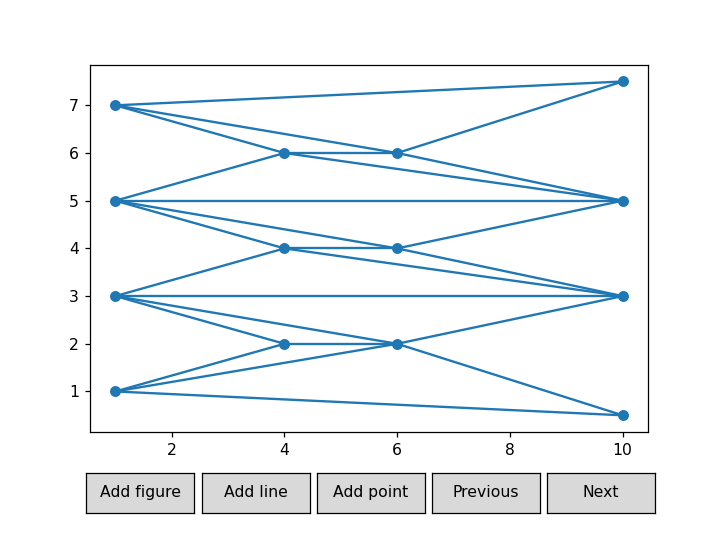

In [92]:
res = triangulateMonotonePolygon(B)
plot = Plot(res[1])
plot.draw()

<IPython.core.display.Javascript object>


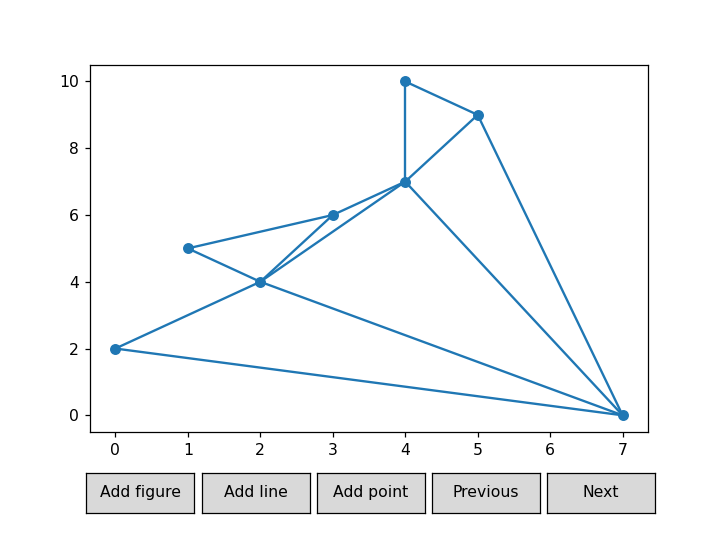

In [48]:
res = triangulateMonotonePolygon(C)
plot = Plot(res[1])
plot.draw()

<IPython.core.display.Javascript object>


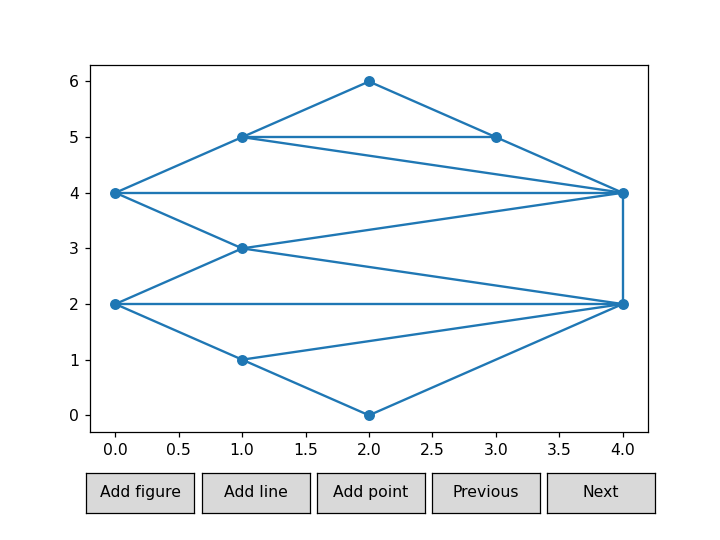

In [76]:
res = triangulateMonotonePolygon(D)
plot = Plot(res[1])
plot.draw()

<IPython.core.display.Javascript object>


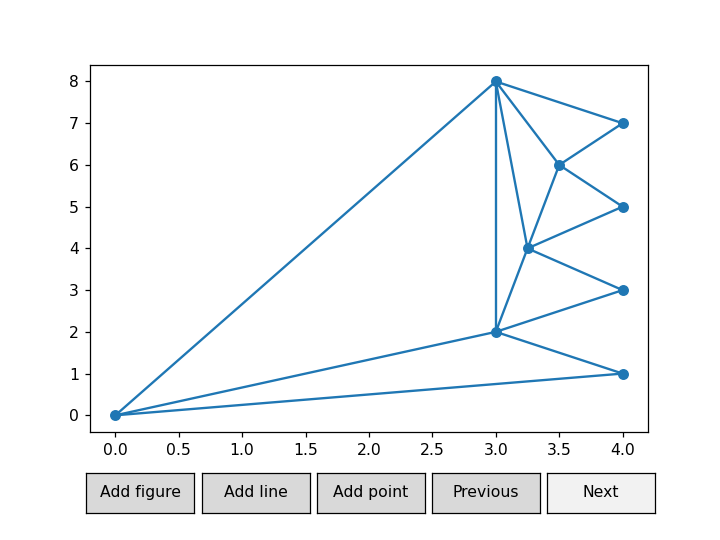

In [94]:
res = triangulateMonotonePolygon([(0, 0), (4, 1), (3, 2), (4, 3), (3.25, 4), (4, 5), (3.5, 6), (4, 7), (3, 8)])
plot = Plot(res[1])
plot.draw()

<IPython.core.display.Javascript object>


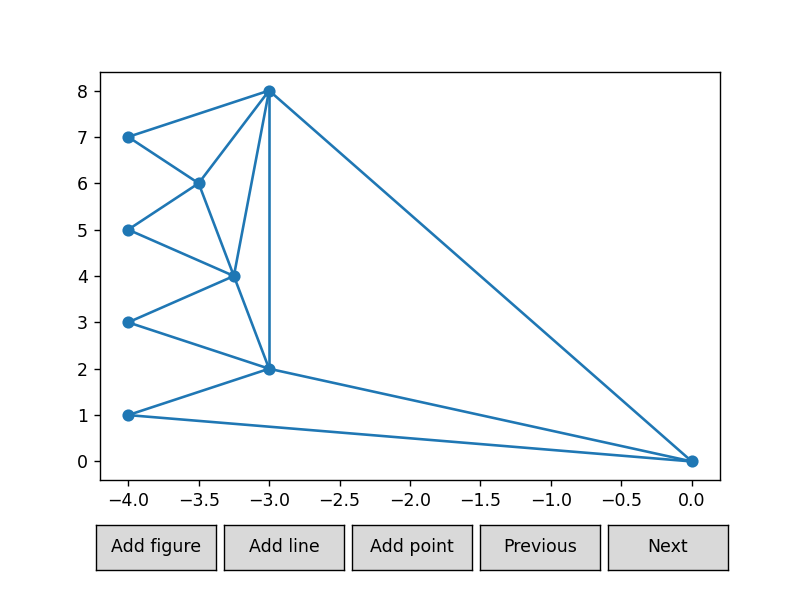

In [103]:
res = triangulateMonotonePolygon([(0, 0), (-3, 8), (-4, 7), (-3.5, 6), (-4, 5), (-3.25, 4), (-4, 3), (-3, 2), (-4, 1)])
plot = Plot(res[1])
plot.draw()